<hr>
<hr>

**Exercício 1** Utilizando a base de dados `breast_cancer`, utilize a clusterização hierárquica para descrever fatores que podem ajudar a indicar se um tumor é maligno ou não. Dica: transforme a feature alvo (`diagnosis`) em número. Use 3 e 5 agrupamentos para a comparação e compare os resultados. Utilize o método de Ward para ligar os clusters. Apresente o dendograma obtido.

<hr>

**Exercício 2** Repita a análise feita anteriormente, porém agora utilizando o DBSCAN. Realize a tunagem dos hiperparâmetros usando o método da silhueta. 

<hr>

### 1 - Importações

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
import scipy.stats as sts
# ignorar warnings
warnings.filterwarnings('ignore')

### 2 - Tratamento Inicial dos Dados

In [2]:
# importar os dados
data = pd.read_csv('../data/breast_cancer.csv')
data.head()


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# eliminar colunas que não serão utilizadas
data.drop(['id'], axis=1, inplace=True)

In [4]:
# separar entre preditores (x) e targets (y)
x = data.drop(['diagnosis'], axis=1)
y = data[['diagnosis']]

# transformar o diagnosis em números
y.diagnosis = y.diagnosis.map({'B': 0, 'M': 1})


In [5]:
# verificando presença dos nulos
data.isna().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [6]:
# verificando se todos os atributos são numéricos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

### 3 - Modelagem

### 3.1 - Funções auxiliares

In [7]:
# processa o modelo ward de acordo com o número de clusters informado
def process(n_clusters):
    
    print(f'Processa Modelo com {n_clusters} clusters')
    
    final_pipe = Pipeline([
        ('scaler', RobustScaler()),
        ('cluster', AgglomerativeClustering(n_clusters=n_clusters, linkage='ward'))
    ])

    # ajuste do modelo
    final_pipe.fit(x)

    # atribuir os clusters
    data['cluster'] = final_pipe['cluster'].labels_
    
    print(data.groupby(['cluster', 'diagnosis'])['diagnosis'].count())

In [8]:
# apresenta um gráfico para análise com 5 colunas obtidas de modo aleatório, tendo em vista que fazer um pairplot com todas as colunas dificulta muito a visualização e análise
def show_graph():
    
    print(f'Pairplot com 5 atributos selecionados aleatoriamente')
    
    # amostrar aleatoriamente 5 colunas do dataset, por questões didáticas
    # numa situação real, deveria selecionar as colunas por correlação ou conversar com a equipe de negócio
    select_cols = list(np.random.choice(x.columns, size=5))

    # é necessário que a coluna cluster esteja presente
    select_cols.append('cluster')

    # cópia do dataset
    data_to_plot = data[select_cols]
    print(data_to_plot)

    #gráfico comparativo
    plt.figure(figsize=(15,15))
    sns.pairplot(data_to_plot, hue='cluster', palette='tab10')
    plt.show()


In [9]:
# realiza o teste ANOVA de acordo com o número de clusters informado
# como visto em aula, os atributos significativos tem um p-value < 0.05
def test_anova(n_clusters):
    
    print(f'Apresenta o resultado do teste ANOVA para cada atributo para {n_clusters} clusters')
    
    columns = x.columns.tolist()
    for col in columns:
        sub_set = []
        for i in range(n_clusters):
            sub_set.append(data.loc[data.cluster==i, col])
        
        # aplicar o teste estatístico de ANOVA
        F, p = sts.f_oneway(*sub_set)    

        print(f'{col} => {p:.4f}')    


In [10]:
# calcula as médias obtidas por cluster definido
def calc_medias():
    print(f'Médias por cluster')
    data.groupby('cluster').mean()

In [11]:
# função para controlar o passo a passo geral de processamento
def run_analysis(n_clusters):
    process(n_clusters)
    show_graph()
    test_anova(n_clusters)
    calc_medias()

### 3.3 - Processamento com 3 clusters

Processa Modelo com 3 clusters
cluster  diagnosis
0        M            103
1        B            339
         M             57
2        B             18
         M             52
Name: diagnosis, dtype: int64
Pairplot com 5 atributos selecionados aleatoriamente
     texture_mean  compactness_se  compactness_mean  concavity_se  \
0           10.38         0.04904           0.27760       0.05373   
1           17.77         0.01308           0.07864       0.01860   
2           21.25         0.04006           0.15990       0.03832   
3           20.38         0.07458           0.28390       0.05661   
4           14.34         0.02461           0.13280       0.05688   
..            ...             ...               ...           ...   
564         22.39         0.02891           0.11590       0.05198   
565         28.25         0.02423           0.10340       0.03950   
566         28.08         0.03731           0.10230       0.04730   
567         29.33         0.06158           0.2

<Figure size 1080x1080 with 0 Axes>

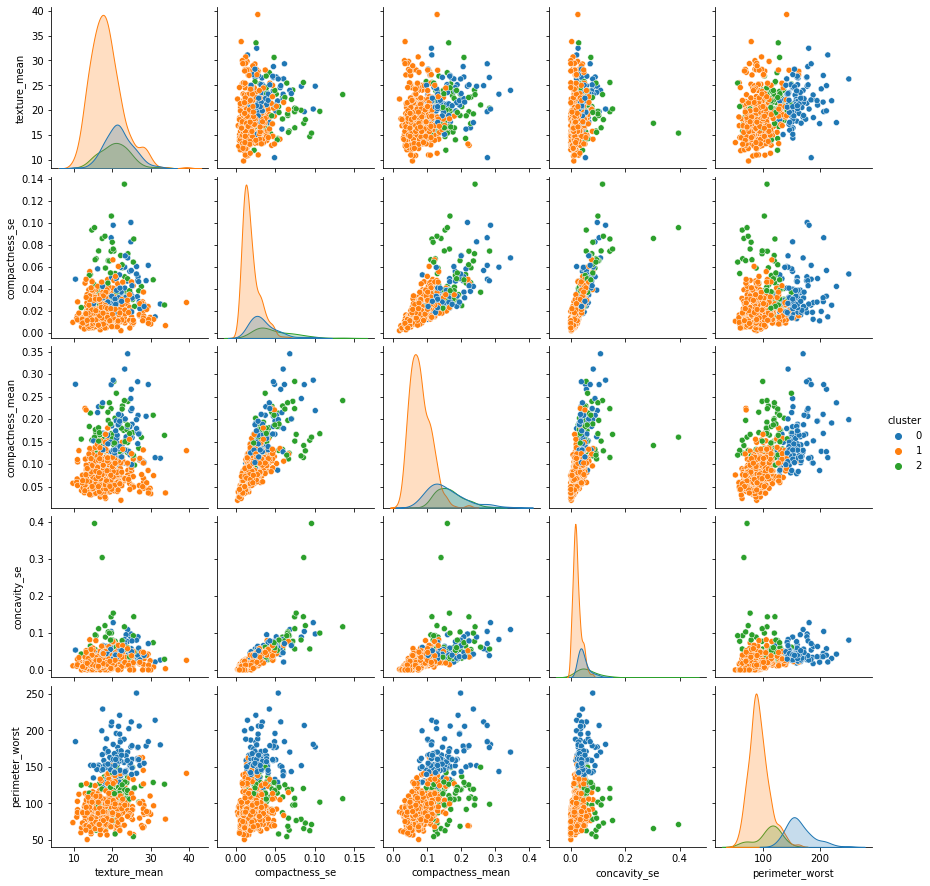

Apresenta o resultado do teste ANOVA para cada atributo para 3 clusters
radius_mean => 0.0000
texture_mean => 0.0000
perimeter_mean => 0.0000
area_mean => 0.0000
smoothness_mean => 0.0000
compactness_mean => 0.0000
concavity_mean => 0.0000
concave points_mean => 0.0000
symmetry_mean => 0.0000
fractal_dimension_mean => 0.0000
radius_se => 0.0000
texture_se => 0.1556
perimeter_se => 0.0000
area_se => 0.0000
smoothness_se => 0.0001
compactness_se => 0.0000
concavity_se => 0.0000
concave points_se => 0.0000
symmetry_se => 0.0000
fractal_dimension_se => 0.0000
radius_worst => 0.0000
texture_worst => 0.0000
perimeter_worst => 0.0000
area_worst => 0.0000
smoothness_worst => 0.0000
compactness_worst => 0.0000
concavity_worst => 0.0000
concave points_worst => 0.0000
symmetry_worst => 0.0000
fractal_dimension_worst => 0.0000
Médias por cluster


In [12]:
n_clusters = 3
run_analysis(n_clusters)


### 3.4 - Processamento com 5 clusters

Processa Modelo com 5 clusters
cluster  diagnosis
0        B            339
         M             57
1        B             15
         M              1
2        M            101
3        M              2
4        B              3
         M             51
Name: diagnosis, dtype: int64
Pairplot com 5 atributos selecionados aleatoriamente
     area_se  concave points_se  radius_worst  texture_se  \
0     153.40            0.01587        25.380      0.9053   
1      74.08            0.01340        24.990      0.7339   
2      94.03            0.02058        23.570      0.7869   
3      27.23            0.01867        14.910      1.1560   
4      94.44            0.01885        22.540      0.7813   
..       ...                ...           ...         ...   
564   158.70            0.02454        25.450      1.2560   
565    99.04            0.01678        23.690      2.4630   
566    48.55            0.01557        18.980      1.0750   
567    86.22            0.01664        25.740    

<Figure size 1080x1080 with 0 Axes>

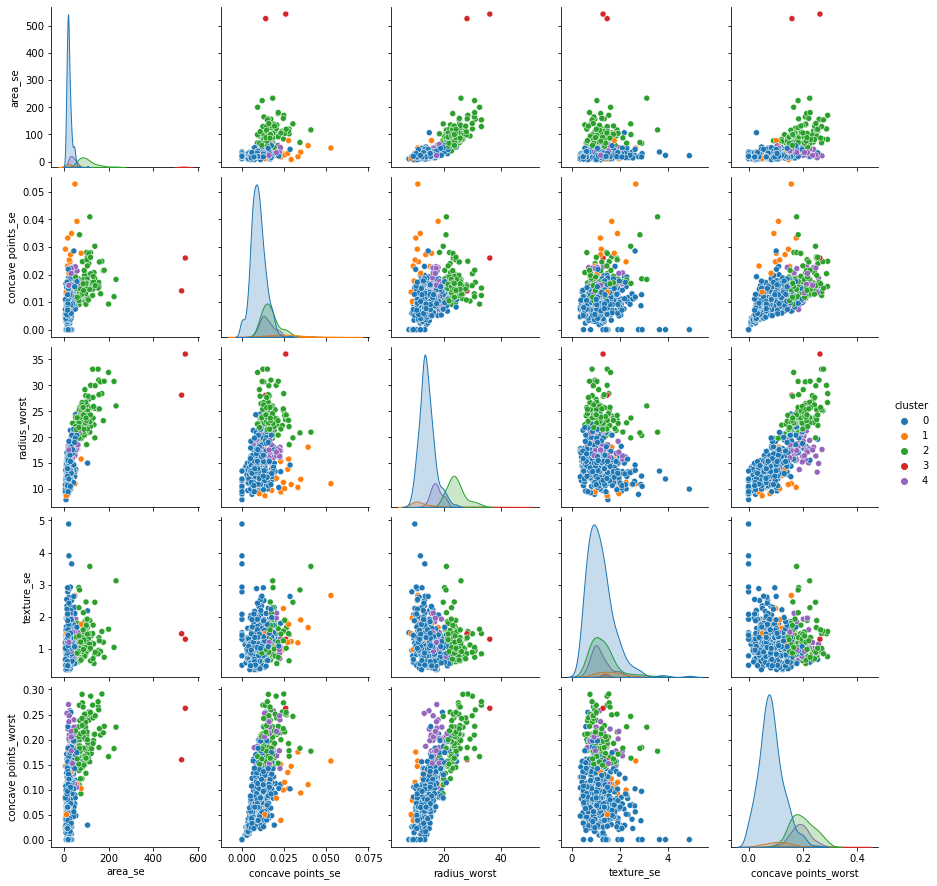

Apresenta o resultado do teste ANOVA para cada atributo para 5 clusters
radius_mean => 0.0000
texture_mean => 0.0000
perimeter_mean => 0.0000
area_mean => 0.0000
smoothness_mean => 0.0000
compactness_mean => 0.0000
concavity_mean => 0.0000
concave points_mean => 0.0000
symmetry_mean => 0.0000
fractal_dimension_mean => 0.0000
radius_se => 0.0000
texture_se => 0.0347
perimeter_se => 0.0000
area_se => 0.0000
smoothness_se => 0.0000
compactness_se => 0.0000
concavity_se => 0.0000
concave points_se => 0.0000
symmetry_se => 0.0000
fractal_dimension_se => 0.0000
radius_worst => 0.0000
texture_worst => 0.0000
perimeter_worst => 0.0000
area_worst => 0.0000
smoothness_worst => 0.0000
compactness_worst => 0.0000
concavity_worst => 0.0000
concave points_worst => 0.0000
symmetry_worst => 0.0000
fractal_dimension_worst => 0.0000
Médias por cluster


In [14]:
n_clusters = 5
run_analysis(n_clusters)


### 4 - Dendograma obtido com método Ward

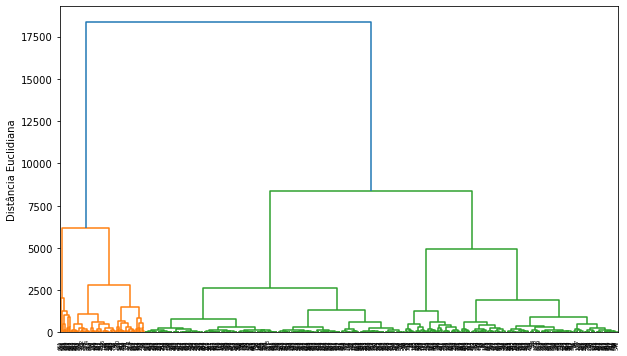

In [15]:
# modelagem
cluster = hierarchy.linkage(x, method='ward')

# criar uma figura
plt.figure(figsize=(10, 6))
dendogram = hierarchy.dendrogram(cluster)
plt.ylabel('Distância Euclidiana')
plt.show()